# News Sentiment Analysis

## Import Libraries

In [1]:
# Common Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
import re
from IPython.display import clear_output
import time
import random

# Cleaner output
from tqdm import tqdm

# Deep Learning Libraries
import torch

# Add the path to the API Scraper
## Project Path
project_path = "../"

## Add the path to API Scraper
sys.path.append(os.path.abspath(os.path.join(project_path, "lib")))

# Custom News Libraries
from scraper import get_cached_news_metadata, extract_text_from_url

# Text preprocessing
from preprocessor import clean_text

## Fetch Data

In [2]:
def scrape_data(n_request: int = 10, before_date: str = "2025-12", path: str = ".", last_idx:int = 0) -> pd.DataFrame:
    
    articles = []

    for i in tqdm(range(last_idx, last_idx + n_request), desc="Fetching News Data...", unit="news"):
        metadata = get_cached_news_metadata(page=i, before_date=before_date, path=path)

        data_list = metadata.get("data", [])

        for article in data_list:
            # extract sentiment (first entity if exists)
            entities = article.get("entities", [])
            if entities and "sentiment_score" in entities[0]:
                sentiment = entities[0]["sentiment_score"]
            else:
                sentiment = None

            # store sentiment as its own field inside article
            article["sentiment"] = sentiment

            articles.append(article)

    # final dataframe
    return pd.DataFrame(articles)

### Caching

In [3]:
# Arguments for the caching function
before_date = "2025-11"

data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(data_path, exist_ok=True) # if the directory exist no need to make

cached_file = os.path.join(data_path, f"{before_date}_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_cached_links = True

# get the last index of the file 
json_files = os.path.join(project_path, f"news_cache/{before_date}/json/page-*.json")
list_of_files = glob.glob(json_files)

## Extract page numbers set to True if you want to get new api request.
get_new_requests = True

if get_new_requests:
    page_nums = []
    for f in list_of_files:
        match = re.search(r"page-(\d+)\.json$", os.path.basename(f))
        if match:
            page_nums.append(int(match.group(1)))

    last_idx = max(page_nums)
    n_requests = 101 # marketaux api limit (last index is excluded)

else:
    last_idx = 0
    n_requests = len(list_of_files) #number of pages we cached to be processed

In [4]:
# filling missing text data function

def safe_extract(row):
    try:
        text = extract_text_from_url(row["url"])
        # print(f"{row['title']} {row['description']}")
        return text

    except Exception as e:
        tqdm.write(f"failed to extract from url \n Err: {e} \n appending title, description, and snippet")
        time.sleep(2)
        print(f"{row['title']} {row['description']}  {row['snippet']}")
        clear_output(wait=True)
        text = f"{row['title']} {row['description']} {row['snippet']}"
        return text

In [5]:
# tqdm for cleaner output
tqdm.pandas(desc="Extracting News from URL's", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(cached_file) and not overwrite_cached_links:
    print("Loading cached dataset...")
    news_df = pd.read_csv(cached_file, sep = ',')
    news_df = pd.DataFrame(news_df)
    print("Cached dataset loaded")

elif os.path.exists(cached_file) and overwrite_cached_links:
    print("Overwriting old data and caching new data...")
    # Scrape the data
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    
    # Extract text from the news
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    news_df = pd.DataFrame(news_df)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    news_df = pd.DataFrame(news_df)
    print("Finished Caching")

Extracting News from URL's: 100%|██████████| 303/303 [07:59<00:00,  1.58s/news] 

Done Overwriting old data and caching new data...


In [6]:
a

NameError: name 'a' is not defined

In [ ]:
# get_cached_news_metadata(page = 140,before_date = before_date, path: str = project_path)

### Fetch the Text from URL

## EDA

### View the Data

In [ ]:
news_df.head(10)

,uuid,title,description,keywords,snippet,url,image_url,language,published_at,source,relevance_score,entities,similar,sentiment,text
0,2e70801f-00a4-4fc9-b1a9-2b41fff3346a,Rabigh Refining and Petrochemical Company (“Pe...,e Saudi Exchange website on 22/06/1440H (corre...,"AAIB, Banking, Visa, Visa Signature, Online Sh...",Latest Developments Of The Announced Event\n\n...,https://english.mubasher.info/news/4509032/Rab...,https://english.mubasher.info/assets/ui/images...,en,2025-10-15T05:57:10.000000Z,english.mubasher.info,None,"[{'symbol': '2380.SR', 'name': 'Rabigh Refinin...",[],0.000000,Latest Developments Of The Announced Event\n\n...
1,934689c4-fa62-42dd-b329-9ef7f2fbe35d,Air Lease signs deal to lease six Airbus jets ...,Air Lease signs deal to supply Magnifica Air w...,,"To ensure this doesn’t happen in the future, p...",https://seekingalpha.com/news/4504138-air-leas...,https://static.seekingalpha.com/assets/og_imag...,en,2025-10-15T05:56:25.000000Z,seekingalpha.com,None,"[{'symbol': 'AL', 'name': 'Air Lease Corporati...",[],0.000000,"To ensure this doesnât happen in the future,..."
2,182ef25b-12b7-4476-8fb5-abb44c81bdfe,Google Meet Revolutionizes Video Calls With Ai...,"Google Meet, the popular online conferencing p...",,"Google Meet, the popular online conferencing p...",https://www.retailnews.asia/google-meet-revolu...,https://www.retailnews.asia/wp-content/uploads...,en,2025-10-15T05:43:54.000000Z,retailnews.asia,None,"[{'symbol': 'MSFT.MI', 'name': 'MICROSOFT CORP...",[],0.000000,"Google Meet, the popular online conferencing p..."
3,59410be0-119d-4b73-8735-fc7c16b3c61f,RH Stock: The Reasons We Are Becoming More Bul...,RH stock is upgraded amid improved performance...,,"Analyst’s Disclosure:I/we have no stock, optio...",https://seekingalpha.com/article/4829987-rh-re...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-10-15T05:41:57.000000Z,seekingalpha.com,None,"[{'symbol': 'RH', 'name': 'RH', 'exchange': No...",[],0.000000,"Analystâs Disclosure:I/we have no stock, opt..."
4,6e53542f-0110-4e4f-ada9-eaabb1866620,Sampo plc’s share buybacks 14 October 2025,"Sampo plc, stock exchange release, 15 October ...","Sampo, plc’s, share, buybacks, 14, October, 2025","Sampo plc, stock exchange release, 15 October ...",https://www.manilatimes.net/2025/10/15/tmt-new...,https://www.manilatimes.net/manilatimes/upload...,en,2025-10-15T05:40:30.000000Z,manilatimes.net,None,"[{'symbol': 'MSCL.SN', 'name': 'MORGAN STANLEY...",[],0.318200,
5,eec50fb1-62d5-401a-a542-68bdbe1ac96a,"Silicon Box Ships 100M Units, Proves Advanced ...",**media[783535]**Breakthrough yield and device...,"Silicon, Box, Ships, 100M, Units, , Proves, Ad...","SINGAPORE, Oct. 15, 2025 /PRNewswire/ -- Silic...",https://www.manilatimes.net/2025/10/15/tmt-new...,https://www.manilatimes.net/manilatimes/upload...,en,2025-10-15T05:39:21.000000Z,manilatimes.net,None,"[{'symbol': 'MRVL', 'name': 'Marvell Technolog...",[],0.340000,
6,abb5bff9-d5c3-4c58-af84-4a637ebec030,Global Markets Rally on Fed Rate Cut Hopes; As...,Asian stock markets largely posted gains today...,,"Key Takeaways\n\nGlobal equities, particularly...",https://stockmarketwatch.com/stock-market-news...,https://stockmarketwatch.com/stock-market-news...,en,2025-10-15T05:38:32.000000Z,thestockmarketwatch.com,None,"[{'symbol': '^AXJO', 'name': 'S&P/ASX 200', 'e...",[],0.059533,"Key Takeaways\n\nGlobal equities, particularly..."
7,7bef5a8e-0639-4930-9cef-8cf9e72b7646,"The Ford F-150 Lightning Is Now Cheaper By $4,...","Ford reduces F-150 Lightning price by $4,000 i...",,Ford Motor Co. (NYSE:F) has reduced the price ...,https://www.benzinga.com/markets/tech/25/10/48...,https://cdn.benzinga.com/files/images/story/20...,en,2025-10-15T05:33:02.000000Z,benzinga.com,None,"[{'symbol': 'F', 'name': 'Ford Motor Company',...",[],-0.169550,Ford Motor Co. (NYSE:F) has reduced the price ...
8,e33c41f0-8da5-4728-b26d-cc2141c699fc,Oracle Stock: The Beginning Of A Long Rally (N...,Oracle is surging as a top AI cloud stoc

### Check for Missing Values

In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0                 0.0
title                         0                 0.0
description                   0                 0.0
keywords                      0                 0.0
snippet                       0                 0.0
url                           0                 0.0
image_url                     0                 0.0
language                      0                 0.0
published_at                  0                 0.0
source                        0                 0.0
relevance_score             303               100.0
entities                      0                 0.0
similar                       0                 0.0
sentiment                     0                 0.0
text                          0                 0.0


### Distribution of the Sentiment Scores

#### Plotting Functions

In [ ]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

#### Data Plots (Before Cleaning)

##### Sentiment Score Distribution

<module 'matplotlib.pyplot' from '/home/horizontal_roterien_katze/miniforge3/envs/thesis/lib/python3.11/site-packages/matplotlib/pyplot.py'>

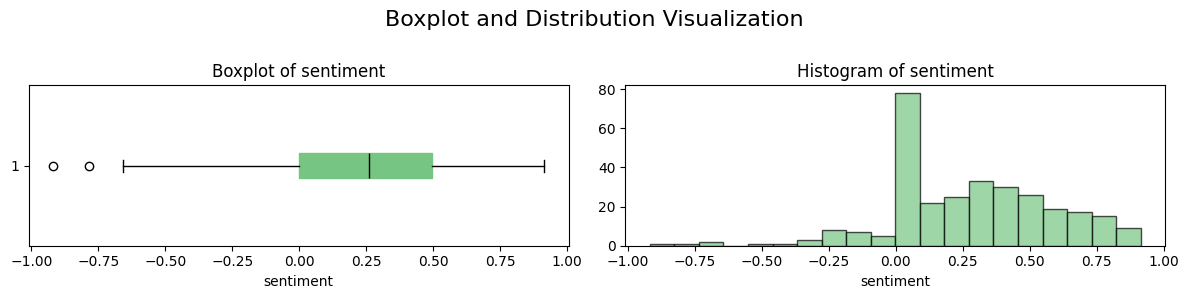

In [ ]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

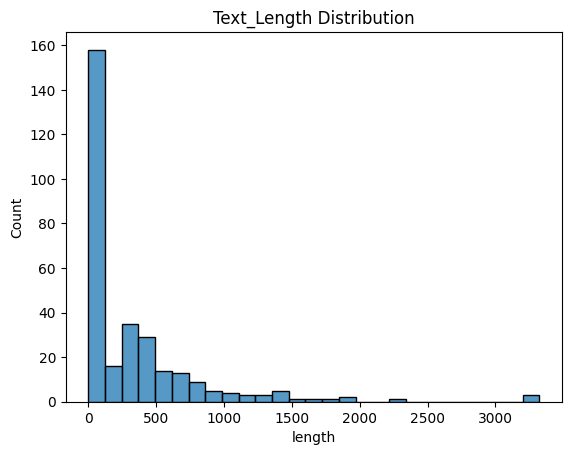

In [ ]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [ ]:
news_df['length'].describe()

count     303.000000
mean      320.957096
std       495.217747
min         0.000000
25%         0.000000
50%        89.000000
75%       425.500000
max      3323.000000
Name: length, dtype: float64

## Data Cleaning

### Fix Missing Values

In [ ]:
news_df["text"] = news_df["text"].replace("", None)

In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                   0            0.000000
keywords                      0            0.000000
snippet                       0            0.000000
url                           0            0.000000
image_url                     0            0.000000
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score             303          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                         94           31.023102
length                        0            0.000000


In [ ]:
news_df["description"] = news_df["description"].fillna('')

#Fill the missing text from the url with just the news description. due to the scraper is unable to get the html since the site requires authorization
news_df["text"] = news_df["text"].fillna(
    news_df["title"].fillna('') + " " + news_df["description"].fillna('') + " " + news_df["snippet"].fillna('')
)

In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0                 0.0
title                         0                 0.0
description                   0                 0.0
keywords                      0                 0.0
snippet                       0                 0.0
url                           0                 0.0
image_url                     0                 0.0
language                      0                 0.0
published_at                  0                 0.0
source                        0                 0.0
relevance_score             303               100.0
entities                      0                 0.0
similar                       0                 0.0
sentiment                     0                 0.0
text                          0                 0.0
length                        0                 0.0


### Drop Duplicated Data

In [ ]:
news_df.drop(columns=["entities", "similar"]).duplicated().sum() # we need to drop the "entitities" and "simmilar" columns due to it being in a list form

np.int64(0)

### Clean the Text

In [ ]:
# Arguments for the caching function
cleaned_data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(cleaned_data_path, exist_ok=True) # if the directory exist no need to make

clean_cached_file = os.path.join(cleaned_data_path, f"{before_date}_clean_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_clean_data = True

In [ ]:
# tqdm for cleaner output
tqdm.pandas(desc="Cleaning the Text", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(clean_cached_file) and not overwrite_clean_data:
    print("Loading cached dataset...")
    news_df = pd.read_csv(clean_cached_file)
    print("Cached dataset loaded")

elif os.path.exists(clean_cached_file) and overwrite_clean_data:
    print("Overwriting old data and caching new data...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Finished Caching")

Overwriting old data and caching new data...


Cleaning the Text:   0%|          | 1/15150 [00:00<00:19, 761.22news/s]


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/home/horizontal_roterien_katze/nltk_data'
    - '/home/horizontal_roterien_katze/miniforge3/envs/thesis/nltk_data'
    - '/home/horizontal_roterien_katze/miniforge3/envs/thesis/share/nltk_data'
    - '/home/horizontal_roterien_katze/miniforge3/envs/thesis/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0                 0.0
title                         0                 0.0
description                   0                 0.0
keywords                      0                 0.0
snippet                       0                 0.0
url                           0                 0.0
image_url                     0                 0.0
language                      0                 0.0
published_at                  0                 0.0
source                        0                 0.0
relevance_score           15150               100.0
entities                      0                 0.0
similar                       0                 0.0
sentiment                     0                 0.0
text                          0                 0.0
length                        0                 0.0


##### Sentiment Score Distribution (After Cleaning)

<module 'matplotlib.pyplot' from '/home/horizontal_roterien_katze/miniforge3/envs/thesis/lib/python3.11/site-packages/matplotlib/pyplot.py'>

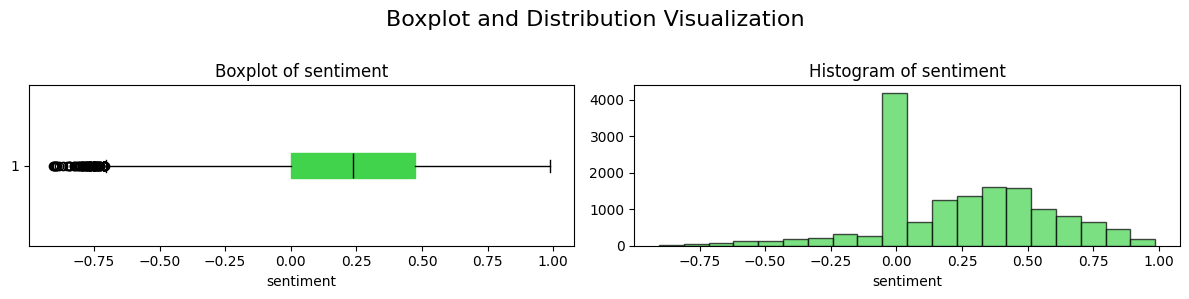

In [ ]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

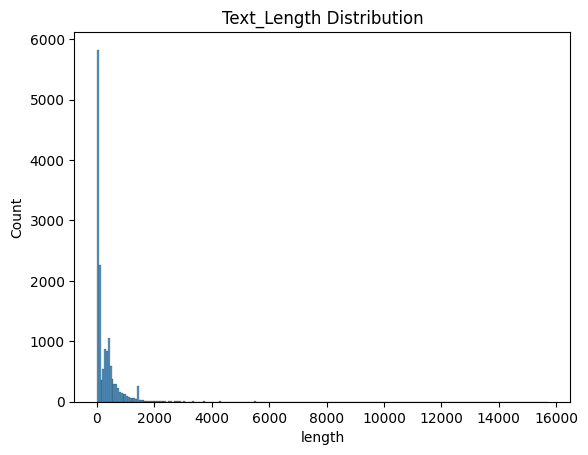

In [ ]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [ ]:
news_df['length'].describe()

count    15150.000000
mean       370.369571
std        802.587240
min          5.000000
25%         58.000000
50%         96.000000
75%        427.000000
max      15708.000000
Name: length, dtype: float64